In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load the cleaned dataset
df = pd.read_csv('cleaned.csv', parse_dates=['Time', 'DateTime'])

In [3]:
df.isnull().sum()

Unnamed: 0          0
Time                0
RT                  0
kW_Tot              0
kW_RT               0
CH Load             0
kW_CHH              0
kW_CHP              0
kW_CHS              0
kW_CDS              0
kW_CT               0
GPM                 0
DeltaCHW            0
CHWS                0
CHWR                0
DeltaCDW            0
CDHI                0
CDLO                0
WBT                 0
DeltaCT             0
Hz_ CHP             0
Hz_CHS              0
Hz_CDS              0
Hz_CT               0
Precent_CH          0
Precent_ CHP        0
Precent_CDS         0
Precent_CT          0
DateTime            0
RH [%]              0
Temperature [°C]    0
WBT_C               0
Time_Difference     0
dtype: int64

In [4]:
# Extract hour, day of the week, and whether it's a weekend
df['Hour'] = df['Time'].dt.hour
df['DayOfWeek'] = df['Time'].dt.dayofweek  # Monday=0, Sunday=6
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

In [5]:
features = [
    'RT', 'kW_Tot', 'kW_RT', 'kW_CHH', 'kW_CHP', 'kW_CHS',
    'kW_CDS', 'kW_CT', 'GPM', 'DeltaCHW', 'CHWS', 'CHWR',
    'DeltaCDW', 'CDHI', 'CDLO', 'DeltaCT', 'Hz_ CHP', 'Hz_CHS',
    'Hz_CDS', 'Hz_CT', 'Precent_CH', 'Precent_ CHP',
    'Precent_CDS', 'Precent_CT', 'RH [%]', 'Temperature [°C]',
    'WBT_C', 'Hour', 'DayOfWeek', 'IsWeekend'
]

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the features
df[features] = scaler.fit_transform(df[features])

In [7]:
# Define the number of previous time steps to consider
sequence_length = 10  # Adjust as needed

# Create sequences
def create_sequences(data, target, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

# Prepare the data
X_data = df[features].values
y_data = df['CH Load'].values  # Assuming 'CH Load' is the target variable

X, y = create_sequences(X_data, y_data, sequence_length)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Example of a deeper model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/Users/sarthaktanwar/Coding/python-projects/r-menCodeCortex/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Determine the split index
train_size = int(0.8 * len(X))

# Split the data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [18]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,  # You can adjust this
    batch_size=32,  # Adjust as needed
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 354.7393 - val_loss: 479.0830
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 351.5401 - val_loss: 480.1146
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 375.6325 - val_loss: 480.9743
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 364.0570 - val_loss: 481.3643
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 369.9077 - val_loss: 481.5509
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 370.9124 - val_loss: 479.6562
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 353.6466 - val_loss: 480.1803
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 363.0409 - val_loss: 482.0285
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 365.8762 - val_loss: 482.0595
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 385.5069 - val_loss: 480.7534
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 348.7147 - val_loss: 480.39

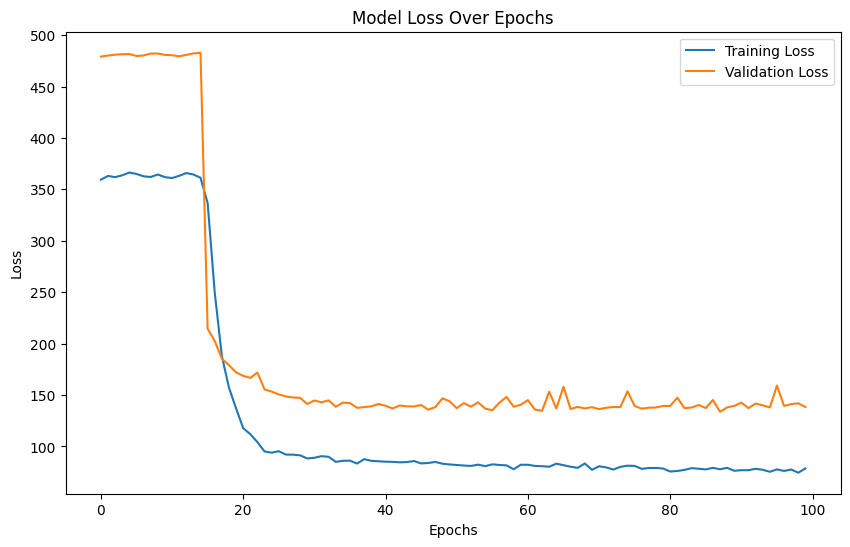

In [19]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# Generate predictions
y_pred = model.predict(X_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'R-squared Score: {r_squared:.4f}')

Mean Absolute Error: 6.7496
Root Mean Squared Error: 11.7651
R-squared Score: 0.6059


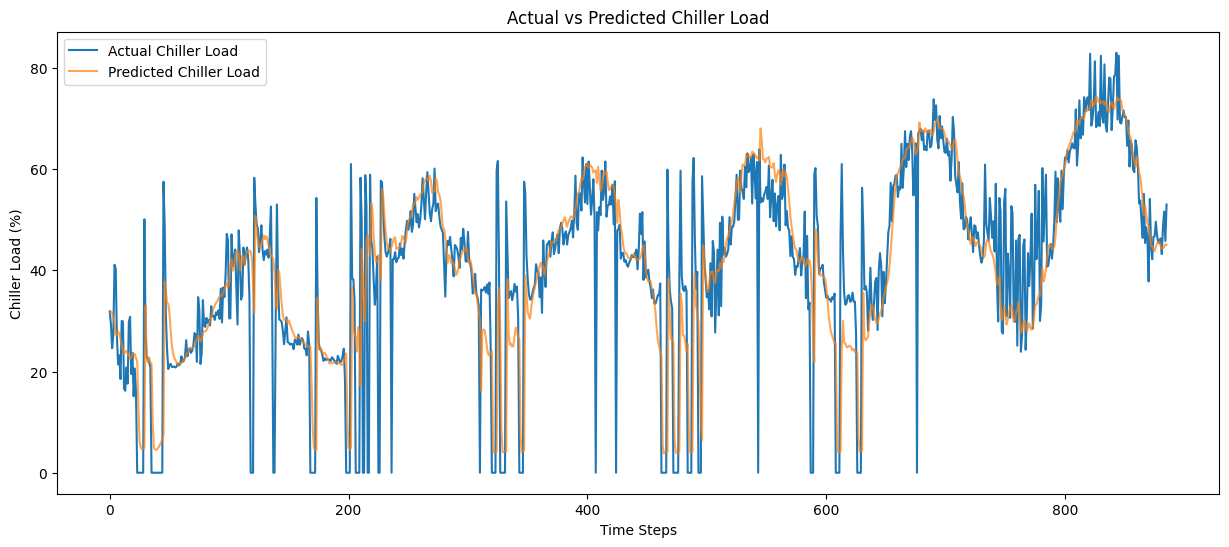

In [22]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Chiller Load')
plt.plot(y_pred, label='Predicted Chiller Load', alpha=0.7)
plt.title('Actual vs Predicted Chiller Load')
plt.xlabel('Time Steps')
plt.ylabel('Chiller Load (%)')
plt.legend()
plt.show()

In [23]:
mean_actual = np.mean(y_test)
cvrmse = (rmse / mean_actual) * 100
print(f'Coefficient of Variation of RMSE (CVRMSE): {cvrmse:.2f}%')

Coefficient of Variation of RMSE (CVRMSE): 28.86%


In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 128)        │        81,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,797 (1.64 MB)

 Trainable params: 143,265 (559.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 286,532 (1.09 MB)

In [25]:
model.save('23_12_model_LSTM.keras')